In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import subprocess
import cv2
from tensorflow.keras.callbacks import EarlyStopping


2024-05-08 11:06:18.633119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 11:06:19.323036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf

if tf.config.experimental.list_physical_devices('GPU'):
    print('GPU disponible')
    for device in tf.config.experimental.list_physical_devices('GPU'):
        print(device)
else:
    print('No hay GPU disponible')
    

GPU disponible
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-05-08 11:06:20.207959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 11:06:20.243834: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 11:06:20.244118: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
def get_gpu_memory():
    """Returns the total memory of the GPU in MB"""
    try:
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.total", "--format=csv,nounits,noheader"], 
            encoding='utf-8')
        return int(result.strip())
    except Exception as e:
        print("Error al obtener la información de la memoria de la GPU:", e)
        return None

# Obtener la cantidad de memoria VRAM disponible en la GPU
total_memory_mb = get_gpu_memory()
if total_memory_mb is not None:
    total_memory_gb = total_memory_mb / 1024
    print("Cantidad total de memoria VRAM en la GPU:", total_memory_gb, "GB")
    
    # Configurar TensorFlow para limitar el uso de memoria GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            # Limitar la memoria GPU al máximo disponible
            tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No se pudo obtener la información de la memoria de la GPU.")

Cantidad total de memoria VRAM en la GPU: 6.0 GB


Leer la base de datos

In [4]:
ruta_archivo = '/home/waldos/Documents/2doCodigo/TopicoIA/Abril/Camera/Entrenamientos/BD_Emotions_Gray.h5'
df  = pd.read_hdf(ruta_archivo)

In [5]:
df.head()


,Imagen,Caracteristicas,Rostro,Etiqueta
0,"[[181, 181, 181, 181, 182, 182, 181, 182, 182,...","[[[60, 68], [60, 74], [61, 80], [62, 86], [65,...","[[27, 25, 33, 28, 19, 23, 33, 22, 23, 42, 79, ...",focused
1,"[[165, 165, 166, 165, 167, 166, 166, 166, 166,...","[[[55, 59], [55, 65], [56, 72], [57, 78], [59,...","[[165, 16, 8, 46, 13, 11, 8, 13, 32, 73, 93, 1...",focused
2,"[[162, 163, 162, 162, 163, 162, 162, 162, 162,...","[[[56, 74], [56, 81], [58, 89], [59, 96], [62,...","[[17, 18, 15, 23, 38, 67, 87, 96, 95, 102, 102...",focused
3,"[[167, 167, 167, 167, 169, 167, 167, 168, 168,...","[[[59, 83], [59, 90], [59, 97], [60, 104], [61...","[[173, 149, 16, 13, 13, 12, 31, 68, 91, 96, 10...",focused
4,"[[171, 169, 170, 168, 171, 172, 170, 170, 171,...","[[[50, 67], [50, 74], [51, 81], [52, 88], [53,...","[[171, 171, 170, 168, 52, 16, 8, 5, 8, 27, 72,...",focused


In [6]:
print(df.shape)

(5023, 4)


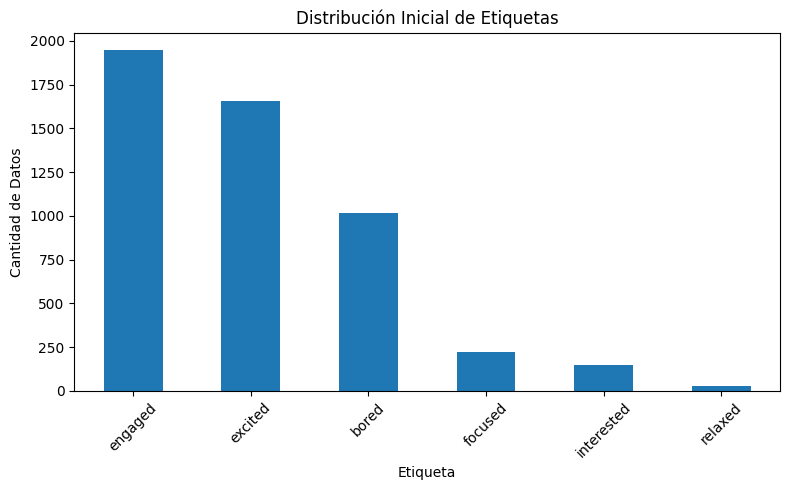

In [7]:
# Visualizar la distribución inicial de etiquetas
plt.figure(figsize=(8, 5))
df['Etiqueta'].value_counts().plot(kind='bar')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución Inicial de Etiquetas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Eliminamos las filas que contengan 

In [8]:
# Filtrar y eliminar las filas que contienen las palabras 'relaxed', 'interesed' y 'focused' en la columna de etiqueta
df = df[~df['Etiqueta'].str.contains('relaxed|interested|focused', case=False)]

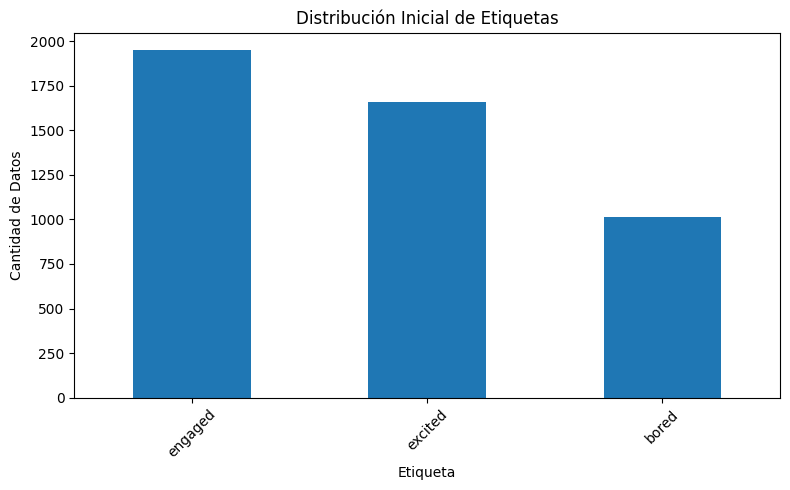

In [9]:
# Visualizar la distribución inicial de etiquetas
plt.figure(figsize=(8, 5))
df['Etiqueta'].value_counts().plot(kind='bar')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución Inicial de Etiquetas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
df.head()

,Imagen,Caracteristicas,Rostro,Etiqueta
250,"[[154, 157, 156, 157, 158, 159, 157, 157, 159,...","[[[59, 64], [59, 72], [61, 80], [62, 88], [64,...","[[167, 166, 166, 18, 14, 35, 102, 18, 24, 39, ...",excited
251,"[[156, 155, 156, 156, 159, 156, 156, 157, 158,...","[[[57, 63], [58, 71], [59, 79], [60, 87], [62,...","[[167, 151, 9, 12, 107, 112, 19, 30, 40, 42, 8...",excited
252,"[[172, 171, 173, 171, 172, 172, 173, 172, 172,...","[[[60, 81], [60, 90], [61, 98], [62, 106], [64...","[[51, 5, 8, 81, 100, 105, 104, 107, 111, 123, ...",excited
253,"[[171, 168, 168, 170, 171, 169, 169, 170, 170,...","[[[62, 86], [62, 92], [64, 97], [65, 102], [67...","[[16, 15, 12, 17, 23, 36, 84, 121, 132, 141, 1...",excited
254,"[[180, 181, 181, 181, 183, 182, 181, 182, 182,...","[[[58, 75], [59, 82], [60, 89], [62, 96], [64,...","[[4, 5, 9, 25, 85, 107, 119, 126, 130, 134, 13...",excited


Verificar que no sea irregular de imagen y rostro

In [11]:
print(df['Imagen'].shape)
print(df['Rostro'].shape)

(4623,)
(4623,)


Separar caracteristicas y etiquetas

In [12]:
X = np.array(df['Rostro'])
y = df['Etiqueta']

Redimensionar

In [13]:
for i in range(X.shape[0]):
    X[i] = cv2.resize(X[i], (150,150))
    X[i] = np.expand_dims(X[i], axis=-1)

In [14]:
print(X[0].shape)

(150, 150, 1)


In [15]:
etiquetas = y.unique()
y_encoded = pd.Categorical(y, categories=etiquetas).codes
print(y_encoded)

[0 0 0 ... 2 2 2]


Hacemos los datos de entrenamiento y los de prueba

In [16]:

# Dividir el dataset en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

Transformar etiquetas a One_hot. Dependiendo la posición del numero es la etiqueta

In [17]:
# Convertir las etiquetas a formato one-hot
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

print(y_val_one_hot)
clases = df['Etiqueta'].unique()
print("Clases originales:", clases)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
Clases originales: ['excited' 'engaged' 'bored']


Visualización de las etiquetas y su clasificación

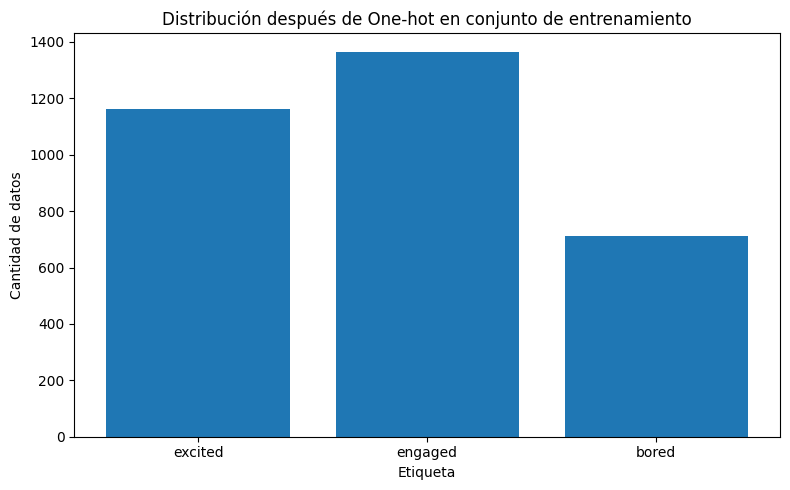

In [18]:
plt.figure(figsize=(8,5))
plt.bar(np.unique(y_train_one_hot.argmax(axis=1)), np.bincount(y_train_one_hot.argmax(axis=1)),align='center')
plt.xticks(np.arange(len(clases)), clases)
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de datos')
plt.title('Distribución después de One-hot en conjunto de entrenamiento')
plt.tight_layout()
plt.show()

Normalizar datos de entrenamiento y de valores en numpy array

In [20]:
X_train = np.array([np.array(x) for x in X_train])
X_val = np.array([np.array(x) for x in X_val])

Todos los datos puestos en float32, divididos en 255 para que sea normalizado del 0 al 1

In [21]:
X_train =X_train.astype('float32')/255
X_val = X_val.astype('float32')/255

Generamos muchas imagenes en distintas posiciones para evitar sobre ajuste.

In [23]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    
)

In [ ]:
train_generator = datagen.flow(X_train, y_train_one_hot, batch_size=32)


Todo el modelo definido